# Hipótesis 4

#### "Las provincias situadas en el sur de España (aquellas al sur de Madrid) tienden a utilizar menos dispositivos de aprovechamiento de energía renovable que las del norte." 

Las diferencias climáticas entre el norte y sur de España pueden ser una variable crucial a la hora de instalar dispositivos de energía renovable pero no la única. El clima influye en la cantidad de energía que se puede producir pero también en la que se consume.

Además puede influir el ámbito socioeconómico, las provincias con mayor poder adquisitivo podrían gastarse más en energía renovable o las más pobres podrían estar motivadas por el ahorro en la factura de la luz. Otras posibles factores de influencia, pueden ser los tamaños familiares o la edad.

## Preparación del entorno

In [ ]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, DistanceMetric

from datawrapper import Datawrapper

GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")

## Datos

Los datos tendrá como base la tarjeta de datos 4 (`data_card_4_df.csv`), de la que se eliminará la variable edad para añadir la variable de `Edad media` de la tarjeta de datos 1 (`data_card_1_df.csv`).

La mediana es una medida más representativa que la media, al no estar influida por valores extremos. Sin embargo, en este caso, la forma de calcular la mediana en el paso de preprocesamiento, hace que la variable de edad esté segmentada en: 42, 47 y 52 años. Por esto, se ha decidido utilizar la media, con valores continuos, y comparar los resultados con los obtenidos usando la mediana.

In [ ]:
# cargar los datos
df1 = pd.read_csv(GOLD_DATA_PATH + "data_card_1_df.csv", sep=";", encoding = 'latin')

df4 = pd.read_csv(GOLD_DATA_PATH + "data_card_4_df.csv", sep=";", encoding = 'latin')
df4.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
# comprobamos valores de edad mediana
print("Valores de la columna de edad mediana: ",df4['Mediana edad'].unique())
print("Valores de la columna de edad media: ",df1['Edad media'].unique())
df4.drop(columns=["Mediana edad"], inplace=True)

In [ ]:
# sustituir la variable edad
df4 = pd.concat([df4, df1['Edad media']], axis=1)
df4.set_index('Provincias', inplace=True)

In [ ]:
df4.head()

## Análisis de datos con clasificación manual

En principio, consideramos la siguiente división de provincias en el norte y sur de España:

In [ ]:
norte=['Araba/Álava', 'Asturias', 'Barcelona', 'Bizkaia', 'Burgos', 'Cantabria', 'Coruña, A', 'Gipuzkoa', 'Girona', 'Guadalajara', 'Huesca', 'León', 'Lleida', 'Lugo', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra', 'Rioja, La', 'Salamanca', 'Segovia', 'Soria', 'Tarragona', 'Teruel', 'Valladolid', 'Zamora', 'Zaragoza', 'Ávila']

df4['Grupo'] = [0 if x in norte else 1 for x in df4.index]

In [ ]:
df4.groupby('Grupo').mean()

Los datos muestran que la implantación de energías renovables es muy similar, aunque en el sur es mayor. Sin embargo, la división hecha puede no ser la más adecuada ya que el criterio de división es muy subjetivo. Por ello, se realizará un análisis de clustering para determinar la división más adecuada.

In [ ]:
df4.drop(columns=['Grupo'], inplace=True)

## Estandarización de los datos

Cada variable tiene una escala diferente, por lo que es necesario estandarizar los datos para que todas tengan la misma importancia en el análisis.
Se ha elegido el MinMaxScaler para que los valores estén entre 0 y 1, intentando modificar lo menos posible la distribución de los datos.

In [ ]:
# Escalado de los datos a un rango de 0 a 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df4)
df4_scaled = pd.DataFrame(scaled_data, columns=df4.columns, index=df4.index)

df4_scaled.head(3)

## Análisis de componentes principales

Para reducir la dimensionalidad de los datos y poder visualizarlos, se aplicará PCA con 2 componentes.

In [ ]:
# Calculo de PCA
from sklearn.decomposition import PCA

estimator = PCA(n_components=2)
X_pca = estimator.fit_transform(scaled_data)

print("Porcentaje de varianza explicado por cada componente:\n", estimator.explained_variance_ratio_)
pd.DataFrame(np.matrix.transpose(estimator.components_), index=df4.columns)

In [ ]:
#Representación 2D
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], s=50)

# anotación 
for i in range(0, len(X_pca)):
    ax.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)
ax.set_title("Representación 2D de los datos")

Si se compara este gráfico con el que se obtiene con la mediana, es una versión espejada.

## Modelado

### Clustering jerárquico

Para el clustering jerárquico se usará el método de Ward, que minimiza la varianza intra-cluster. Y la métrica de distancia será la euclídea.

In [ ]:
# distancia euclidea entre las provincias
dist = DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(scaled_data)
ax = sns.heatmap(matsim,vmin=0, vmax=1)
plt.show()

En el gráfico predominan los colores claros, lo que indica que en general, las provincias están bastante distantes entre sí. A continuación, se mostrará un dendrograma para ver la jerarquía de los clusters.

In [ ]:
# metodo ward y dendrograma
link_matrix_avg = linkage(df4_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(8, 5))
dendrogram(link_matrix_avg, labels=df4_scaled.index)
plt.show()

El dendrograma muestra que hay 2 clusters. 

Se calculará el coeficiente de silhouette para evaluar la calidad del distintas configuraciones de clusters.

In [ ]:
# Visualización de diferente número de clusters
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(2, 10):
    clusters = fcluster(link_matrix_avg, t=i, criterion='maxclust')  # Generar i clusters
    scatter = axes[i-2].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, s=50, cmap='rainbow')
    coef = silhouette_score(df4_scaled, clusters)
    axes[i-2].legend(*scatter.legend_elements(), title="Clusters")
    axes[i-2].set_title(f'{i} Clusters score: {coef:.3f}')

plt.tight_layout()
plt.show()

El gráfico muestra que la configuración con 2 clusters es la que tiene un coeficiente de silhouette más alto, con un valor de 0.329.

In [ ]:
# seleccionamos 2 clusters usando el criterio de maxclust
clusters = fcluster(link_matrix_avg, t=2, criterion='maxclust')

In [ ]:
# visualización del resultado
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=clusters, cmap='plasma_r')

# nombres de las provincias 
for i in range(0, len(X_pca)):
    plt.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

handles, labels = scatter.legend_elements()
legend = plt.legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Resultados

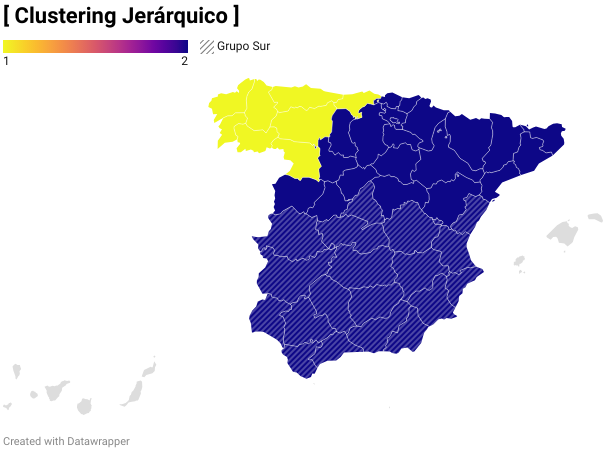

Estos resultados indican que sí se pueden agrupar las provincias en 2 grupos de norte y sur, aunque los grupos no son los que habíamos definido en la hipótesis inicial. En el mapa las provincias con una sombra gris son las que originalmente pertenencían al grupo del sur, y el resto al del norte. 

Sin embargo, los colores indican dos grupos: noroeste y el resto de la península. En el noroeste están las provincias de Asturias, Ourense, Lugo, A Coruña, Pontevedra, Cantabria, León y Zamora.

A continuación, se analizarán las características de los clusters.

In [ ]:
df4_scaled['Cluster'] = clusters
df4_melted = df4_scaled.melt(id_vars="Cluster", var_name="Variable", value_name="Valor")
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Valor", hue="Cluster", data=df4_melted, palette="Set3")
plt.title("Distribución de las variables por cluster")
plt.xticks(rotation=90)
plt.show()

In [ ]:
df4[df4_scaled['Cluster'] == 1].describe()

Las características del cluster 1, las provincias del noroeste, son:
- Menor implantación de energía renovable, con una media de **3.7%** de hogares con dispositivos de energía renovable.
- Renta media por hogar ligeramente inferior al otro cluster, con una media de **30.483€**.
- Menor producción media de energía solar y con valores más dispersos (por el clima de la zona, tienen menos horas de sol).
- Mayor porcentaje de familias con 0 y 1 hijos.
- Menor porcentaje de familias con muchos hijos.
- Edad media mayor, con un valor de **48.6 años**.

## Conclusión 

Hipótesis: *"Las provincias situadas en el sur de España (aquellas al sur de Madrid) tienden a utilizar menos dispositivos de aprovechamiento de energía renovable que las del norte."*

El resultado del clustering jerárquico demuestra que la división inicial de las provincias era incorrecta y que la división ideal, si queremos comparar dos grupos, es: noroeste y resto de la península. 

Las provincias del noroeste tienen una menor implantación de energía renovable. Por lo que el sur, es el que mayor implantación tiene, teniendo en cuenta los siguientes factores: edad, climatología, tamaño de la familia y renta.

----------------------------

## Clasificación y clustering

Para verificar los resultados obtenidos, se realizará una división de las provincias en norte y sur y se etiquetarán los grupos. De esta forma, se quiere comprobar si forzando la división en 2 grupos, se obtienen los mismos resultados que con el clustering jerárquico.

In [ ]:
# Provincias en el dataset
df4.index

In [ ]:
norte=['Araba/Álava', 'Asturias', 'Barcelona', 'Bizkaia', 'Burgos', 'Cantabria', 'Coruña, A', 'Gipuzkoa', 'Girona', 'Guadalajara', 'Huesca', 'León', 'Lleida', 'Lugo', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra', 'Rioja, La', 'Salamanca', 'Segovia', 'Soria', 'Tarragona', 'Teruel', 'Valladolid', 'Zamora', 'Zaragoza', 'Ávila']

df4['Grupo'] = [0 if x in norte else 1 for x in df4.index]

In [ ]:
df4.head()

In [ ]:
df4['Grupo'].value_counts()

## Entrenamiento y validación

Se entrenará un modelo de clasificación, en este caso se ha elegido Random Forest, y se sacará el valor de relevancia de cada variable para volver a clusterizar y comparar los resultados.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df4.drop(columns=["Grupo"])
y = df4["Grupo"]

# se divide el dataset en 30-70 para que el modelo no entrene con demasiados datos y evitar el overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30, stratify=y)

rf = RandomForestClassifier(n_estimators=10, random_state=30)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

In [ ]:
# Evaluación de resultados
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
cm = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
cm_display.plot()
plt.title("Confussion Matrix")
print(classification_report(y_test, pred))

El modelo muestra buenos resultados durante el entrenamiento. Pero al tener muy pocos datos, se comprobarán los resultados usando validación cruzada del tipo Leave One Out. Este tipo de validación tiene un gran coste computacional con grandes volumenes de datos, pero al tener pocos, es la mejor opción.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

scores = cross_val_score(rf, X, y, cv=LeaveOneOut())
print(f"Accuracy: {scores.mean():.2f}")

In [ ]:
print ('================= Feature Relevances ====================')
importance = pd.DataFrame({'Attributes': X_train.columns,
            'Feature importance':rf.feature_importances_}).sort_values('Feature importance', ascending=False)
print(importance)

In [ ]:
# seleccion de las dos variables más importantes
variables = importance.iloc[:2]['Attributes'].values

In [ ]:
selection = df4_scaled[variables]

link_matrix_avg = linkage(selection, method='ward', metric='euclidean')

plt.figure(figsize=(8, 5))
dendrogram(link_matrix_avg, labels=df4.index)
plt.show()

In [ ]:
clusters = fcluster(link_matrix_avg, t=2, criterion='maxclust')
print("coeficiente de silhouette: ",silhouette_score(selection, clusters))

Resultados del clustering jerárquico después de realizar la selección de características:

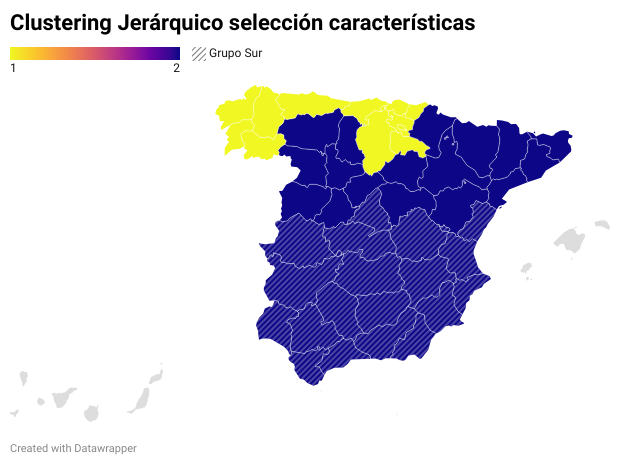

Los resultados son similares a los obtenidos en el primer clustering jerárquico, aunque tenía un menor coeficiente de silhouette. Las provincias de Galicia, Asturias y Cantabria siguen agrupadas en el mismo cluster.

Sin embargo, la selección de características depende del parámetro `random_state` del modelo Random Forest, por lo que los resultados pueden variar y no se usarán para la interpretación final.